### Poetry generation (for real)

Let's try to generate some poetry using RNNs. 

What to use: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/25s_harbour/homeworks/lab02_language_modeling/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(text).lower()

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
token_to_id = {token: id for id, token in enumerate(tokens)}

# dict <char>:<index>
id_to_token = {id: token for id, token in enumerate(tokens)}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)        
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        x: batch of character indices
        h_prev: previous hidden state
        """
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        
        h_next = torch.tanh(self.rnn_update(x_and_h))
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return empty (zero) state for the beginning of a sequence """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Iteration 250/2000, Loss: 2.2550
Iteration 500/2000, Loss: 2.0393
Iteration 750/2000, Loss: 1.8730
Iteration 1000/2000, Loss: 1.8379
Iteration 1250/2000, Loss: 1.7896
Iteration 1500/2000, Loss: 1.7810
Iteration 1750/2000, Loss: 1.7227
Iteration 2000/2000, Loss: 1.7274


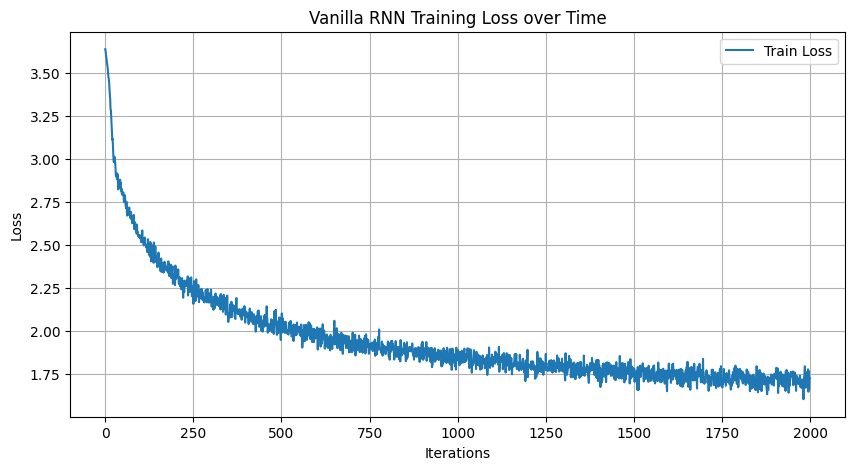

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def rnn_loop(model, batch_ix):
    batch_size, seq_length = batch_ix.size()
    
    hid_state = model.initial_state(batch_size)
    
    logits_seq = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = model(x_t, hid_state)
        logits_seq.append(logits)

    return torch.stack(logits_seq, dim=1)

num_tokens = len(tokens)
model = CharRNNCell(num_tokens=num_tokens, embedding_size=16, rnn_num_units=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

history = []
n_iterations = 2000
batch_size = 32
seq_len = 64

def get_random_batch(text, batch_size, seq_len):
    indices = []
    for _ in range(batch_size):
        start = np.random.randint(0, len(text) - seq_len - 1)
        chunk = text[start : start + seq_len + 1]
        indices.append([token_to_id[c] for c in chunk])
    return torch.tensor(indices, dtype=torch.long)

for i in range(n_iterations):
    batch_ix = get_random_batch(text, batch_size, seq_len)
    
    logits_seq = rnn_loop(model, batch_ix)
    
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = loss_func(
        predictions_logits.reshape(-1, num_tokens),
        actual_next_tokens.reshape(-1)
    )
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    
    if (i + 1) % 250 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Loss: {loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history, label='Train Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Vanilla RNN Training Loss over Time")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
def generate_sample(char_rnn, seed_phrase="shall i ", max_length=200, temperature=1.0):
    char_rnn.eval()
    with torch.no_grad():
        x_sequence = [token_to_id[token] for token in seed_phrase]
        
        hid_state = char_rnn.initial_state(batch_size=1)

        for i in range(len(seed_phrase) - 1):
            x_t = torch.tensor([x_sequence[i]], dtype=torch.int64)
            hid_state, _ = char_rnn(x_t, hid_state)

        for _ in range(max_length - len(seed_phrase)):
            x_t = torch.tensor([x_sequence[-1]], dtype=torch.int64)
            
            hid_state, logits = char_rnn(x_t, hid_state)
            
            p_next = F.softmax(logits / temperature, dim=-1).cpu().numpy()[0]

            next_ix = np.random.choice(len(tokens), p=p_next)
            x_sequence.append(next_ix)

        return "".join([id_to_token[ix] for ix in x_sequence])



In [30]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(model, seed_phrase="shall i ", max_length=100, temperature=0.8))

shall i ffad hast exxy'd.
    leasuther dialst 'othing hall strasse and heast then dost thee ferst t


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

Iteration 500, Loss: 1.9097
Iteration 1000, Loss: 1.7332
Iteration 1500, Loss: 1.6720
Iteration 2000, Loss: 1.5591


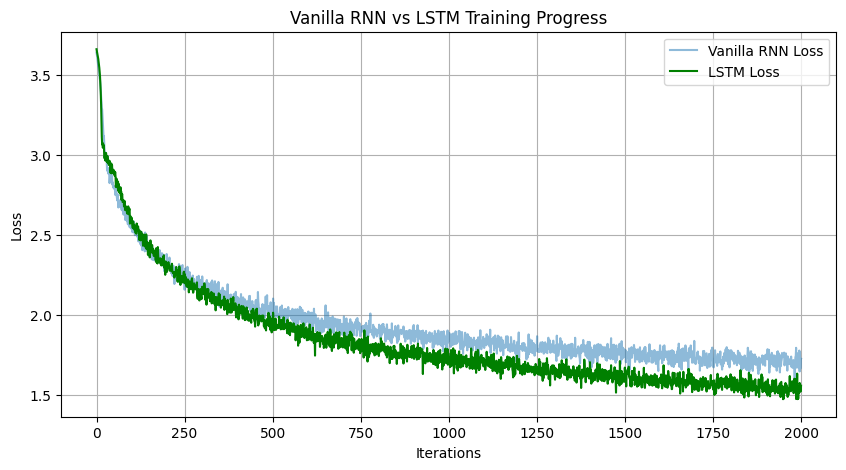

In [31]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens, embedding_size=16, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (h_prev, c_prev) = prev_state
        x_emb = self.embedding(x)
        h_next, c_next = self.lstm(x_emb, (h_prev, c_prev))
        logits = self.rnn_to_logits(h_next)
        return (h_next, c_next), logits
    
    def initial_state(self, batch_size):
        device = next(self.parameters()).device
        return (torch.zeros(batch_size, self.num_units, device=device),
                torch.zeros(batch_size, self.num_units, device=device))

def rnn_loop(model, batch_ix):
    batch_size, seq_length = batch_ix.size()
    hid_state = model.initial_state(batch_size) 
    logits_seq = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = model(x_t, hid_state)
        logits_seq.append(logits)
    return torch.stack(logits_seq, dim=1)


num_tokens = len(tokens)
model_lstm = CharLSTMCell(num_tokens=num_tokens, rnn_num_units=128)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

history_lstm = []
n_iterations = 2000

for i in range(n_iterations):
    batch_ix = get_random_batch(text, batch_size=32, seq_len=64)
    logits_seq = rnn_loop(model_lstm, batch_ix)
    
    loss = loss_func(
        logits_seq[:, :-1].reshape(-1, num_tokens),
        batch_ix[:, 1:].reshape(-1)
    )
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history_lstm.append(loss.item())
    if (i + 1) % 500 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history, label='Vanilla RNN Loss', alpha=0.5)
plt.plot(history_lstm, label='LSTM Loss', color='green')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Vanilla RNN vs LSTM Training Progress")
plt.legend()
plt.grid(True)
plt.show()

Yes, the LSTM loss is lower (closer to 1.5–1.6) compared to the Vanilla RNN (1.7–1.9).

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [32]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seed = "shall i "

for temp in temperatures:
    print(f"\n--- Temperature: {temp} ---")
    sample = generate_sample(model_lstm, seed_phrase=seed, max_length=150, temperature=temp)
    print(sample)


--- Temperature: 0.1 ---
shall i have the words of thee,
  and the so the world the sours of thee thee so thee,
  and the world the sould the world the world thee the sours of

--- Temperature: 0.2 ---
shall i seem thee thou hast the sweet in thee do not thee thee,
  and the words of the sould the summer thee thee doth love thee the with thee thee,
 

--- Temperature: 0.5 ---
shall i love thee,
  in proud thee from shall more the farte as thee in that amend,
  then thou beauty can my my may their beauty sun their past,
  th

--- Temperature: 1.0 ---
shall i wroms.
  lour: the rage this it tone and midor ausred.
    they prower's nut my muck intier's ang my ofance to the notion?
    my fow, the gra

--- Temperature: 2.0 ---
shall i ocalthor hwming hy ginveo!
  or erow' otrobe; are hond bursor, in it
  picdmaso dlysj ithen: ouis'dfal'!
   thy kijh iw gark bweet'd 'ghis lek


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [33]:
import torch

PATH = "shakespeare_lstm.pt"

torch.save(model_lstm.state_dict(), PATH)
print(f"Model was saved to {PATH}")

loaded_model = CharLSTMCell(num_tokens=len(tokens), embedding_size=16, rnn_num_units=128)
loaded_model.load_state_dict(torch.load(PATH))

loaded_model.eval()
print("Model was succsesfully load!")

seed = "thine eyes "
generated_text = generate_sample(
    loaded_model, 
    seed_phrase=seed, 
    max_length=100, 
    temperature=0.7
)

print(generated_text)

Model was saved to shakespeare_lstm.pt
Model was succsesfully load!
thine eyes fame be gole,
  and came me that true thee hearth the self of see;
  for thy that when th


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT